# Programming Exercise 3: Multi-class Classification and Neural Networks
*Code's author: Natália Tenório Maia*<br>
*Solution for [Exercise 3](https://www.coursera.org/learn/machine-learning/home/week/4) of Coursera's Machine Learning course by Andrew Ng.*
<br>
<br>
There are many different ways to solve this exercise. Here you will learn just one possible way, where I tried to stick with the original idea proposed in the exercise's pdf.
<br>
<br>
In this exercise, we will implement one-vs-all logistic regression and neural networks to recognize hand-written digits.

## Part 1 - Multi-class Classification
For this exercise, you will use logistic regression and neural networks to recognize handwritten digits (from 0 to 9). Automated handwritten digit recognition is widely used today - from recognizing zip codes (postal codes) on mail envelopes to recognizing amounts written on bank checks. This exercise will show you how the methods you’ve learned can be used for this classification task.
 <br>
**Goal:** In the first part of the exercise, you will extend your previous implementation of logistic regression and apply it to one-vs-all classification.
<br>
### Importing data

In [1]:
import numpy as np                 # package for scientific computing
import matplotlib.pyplot as plt    # plotting library
from scipy import optimize as opt  # package for optimizing functions
from scipy.io import loadmat       # package for loading MatLab files

dataset = loadmat('ex3data1.mat')

X = dataset['X']      # input training set
y = dataset['y']      # output training set
m = X.shape[0]        # number of examples
n = X.shape[1]        # number of features
K = len(np.unique(y)) # number of classes
y[y==10]=0            # fixing the values related to the number 0, since 0 is a valid index in Python.

### Visualizing data

You will begin by visualizing a random subset of the training set.

In [2]:
# This displays data stored in X in a 2D grid:
def displaydata(X, figsize):
    # Determines the number of rows, cols of the entire figure:
    if X.ndim == 2:
        m, n = X.shape
    elif X.ndim == 1:
        m = 1; n = X.size
        X = X[None]  # transforms X into a 1xn array
    else:
        raise IndexError('The input X should be a 1 or 2 dimensional numpy array.')
    # For each individual example to be displayed, we have to determine its dimensions:
    ex_width = int(np.round(np.sqrt(n))); ex_height = int(np.round(n/ex_width))        
    # Determines the number of items to be displayed in the figure:
    fig_rows = int(np.floor(np.sqrt(m))); fig_cols = int(np.ceil(m /fig_rows))
    # Creates a figure (fig) with an array (ax_array) of subplots:
    fig, ax_array = plt.subplots(fig_rows, fig_cols, figsize=figsize)
    # Adjust spacing between subplots:
    fig.subplots_adjust(wspace=0.1, hspace=0.1)

    ax_array = [ax_array] if m == 1 else ax_array.ravel()
    for i in range(len(ax_array)):
        ax_array[i].imshow(X[i].reshape(ex_width, ex_height, order='F'),cmap='magma'); ax_array[i].axis('off')

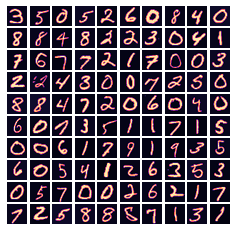

In [3]:
# Now we randomly select 100 of the 5000 rows in the input training dataset:
rand = np.random.choice(m, 100, replace=False)
rand_data = X[rand, :]
# Here we display the 100 numbers encoded in these selected data:
displaydata(rand_data,(4,4))

### Implementing cost function

In [4]:
# Simplified matrix multiplication command:
def MM(A,B):
    return np.matmul(A,B)
    
# Logistic regression hypothesis or sigmoid function:
def g(theta,X):
    #theta = theta.reshape(-1,1)
    return 1/(1+np.exp(-MM(X,theta)))

# Regularized cost function:
def costfunction_reg(theta,X,y,lamb):
    m = X.shape[0]
    theta = theta.reshape(-1,1)
    thetamod = np.append([0],theta[1:len(theta)]).reshape(-1,1)
    h = 1/(1+np.exp(-MM(X,theta)))
    J = -(1/m)*(MM(y.T,np.log(h))+MM((1-y.T),np.log(1-h)))+(lamb/(2*m))*MM(thetamod.T,thetamod)
    grad = ( (1/m)*MM(X.T,(h-y)) + (lamb/m)*thetamod ).flatten()
    return float(J), grad

In [5]:
# test values:
theta_t = np.array([-2, -1, 1, 2], dtype=float)
X_t = np.concatenate([np.ones((5, 1)), np.arange(1, 16).reshape(5, 3, order='F')/10.0], axis=1)
y_t = np.array([1, 0, 1, 0, 1]).reshape(-1,1)
lamb_t = 3

costfunction_reg(theta_t,X_t,y_t,lamb_t)

(2.534819396109744,
 array([ 0.14656137, -0.54855841,  0.72472227,  1.39800296]))

The test results above are in agreement with file ex3.m .

### Implementing One vs All classification

In this part of the exercise, you will implement one-vs-all classification by training multiple regularized logistic regression classifiers, one for each of the K classes in our dataset. In the handwritten digits dataset, K = 10, but your code should work for any value of K.

In [6]:
def OnevsAll(X,y,K,lamb):
    """
    This function provides the matrix of fitted parameter for a multiclass logistic regression problem.
    
    X: input training dataset
    y: output training dataset
    K: number of classes
    lamb: regularization parameter
    """
    initial_theta = np.zeros((n+1,1))                 # initial guess for theta as a n+1-tuple
    all_theta = np.zeros((K,n+1))                     # matrix to insert the values of theta for each class
    for k in range(K):
        y_k = np.array([1 if i==k else 0 for i in y]).reshape(-1,1)
        optmin = opt.minimize(costfunction_reg,initial_theta,(X,y_k,lamb),
                              jac=True,method='TNC',options={'maxiter': 50})
        all_theta[k] = optmin.x
    all_theta = all_theta.T
    return all_theta

X = np.append(np.ones((m,1)),dataset['X'],axis=1) # adding the unit column related to x0   
# Finally, the fitted parameters are:
Theta = OnevsAll(X,y,K,0.1)
Theta.shape

(401, 10)

In [7]:
# Hypothesis:
h = g(Theta,X)
# Prediction:
p = np.array([int(np.where(h[i] == h[i].max())[0]) for i in range(len(h))]).reshape(-1,1)
p.shape

(5000, 1)

In [8]:
# Accuracy:
np.mean(p==y)

0.952

The result above agrees with ex3.m  . Notice that the choice of the maximum number of iterations can slightly change the accurary of the model. It turns out that options={'maxiter': 50} provides an accuracy similar to that presented in ex3.m .

### Part 2 - Neural Networks

In this part of the exercise, you will implement a neural network to recognize handwritten digits using the same training set as before. The neural network will be able to represent complex models that form non-linear hypotheses. For this week, you will be using parameters from a neural network that we have already trained. <br>
**Goal:** Your goal is to implement the feedforward propagation algorithm to use our weights for prediction.

For this case, we will use a NN with 3 layers:<br>
$a^{(1)}$: input layer $a^{(1)}=X_{5000\times401}$ with parameters $\Theta^{(1)}_{401\times25}$ ;<br>
$a^{(2)}$: hidden layer $a^{(2)}=g(a^{(1)} \Theta^{(1)})_{5000\times26}$ wtih parameters $\Theta^{(2)}_{26\times10}$;<br>
$a^{(3)}$: output layer $a^{(3)}=g(a^{(2)} \Theta^{(2)})_{5000\times10}$.<br>

This is the architecture of the NN we will build:

<img src="NN.png" width="320"/>

OBS: The +1 refers to the bias units related to the input and the hidden layers.

### Importing data

In [9]:
datatheta = loadmat('ex3weights.mat')

Theta1 = datatheta['Theta1'].T
# For Theta2, which takes the hidden layer to the output layer, we have to swap the first and
# the last columns because we are not using the number "10" for indexing but "0":
Theta2 = np.roll(datatheta['Theta2'], 1, axis=0).T

In [10]:
# We already know X from Part 1:
print(X.shape)

(5000, 401)


### Implementing Feedforward Propagation

In [11]:
def pred(Theta,X):
    L = len(Theta)+1        # number of layers
    a = [0]*L               # list of layers
    a[0] = X                # the first layer is the input layer, which already has bias unit included
    for i in range(1,L):
        if i < L-1:
            # computes hidden layer and adds the bias unit to it:
            a[i] = np.append(np.ones((len(a[i-1]),1)),g(Theta[i-1],a[i-1]),axis=1) 
        else:
            # computes the output layer:
            a[i] = g(Theta[i-1],a[i-1])
    # The hypothesis is the output layer:
    h = a[L-1]
    # Prediction:
    p = np.array([int(np.where(h[i] == h[i].max())[0]) for i in range(len(h))]).reshape(-1,1)
    return  p

### Prediction

In [12]:
Theta = [Theta1,Theta2] # list of given parameters
p = pred(Theta,X)
p.shape

(5000, 1)

In [13]:
Theta = [Theta1,Theta2] # list of given parameters
L = len(Theta)+1        # number of layers
a = [0]*L               # list of layers
a[0] = X                # the first layer is the input layer, which already has bias unit included
for i in range(1,L):
    if i < L-1:
        # computes hidden layer and adds the bias unit to it:
        a[i] = np.append(np.ones((len(a[i-1]),1)),g(Theta[i-1],a[i-1]),axis=1) 
    else:
        # computes the output layer:
        a[i] = g(Theta[i-1],a[i-1])
a[2].shape
a[2][0]

array([9.95734012e-01, 1.12661530e-04, 1.74127856e-03, 2.52696959e-03,
       1.84032321e-05, 9.36263860e-03, 3.99270267e-03, 5.51517524e-03,
       4.01468105e-04, 6.48072305e-03])

In [14]:
np.mean(p==y)

0.9752

The result above agrees with what is presented in ex3.pdf .

We can visualize how well our model is doing by displaying the data it uses to predict and the prediction simultaneously:

Prediction: 7
Data used to make prediction:


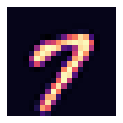

In [15]:
# Let's pick any example, for instance 3500:
example = X[3500, :].reshape(1,-1)
p = pred(Theta,example)
# Here we display the 100 numbers encoded in these selected data:
print('Prediction: '+str(int(p)))
print('Data used to make prediction:')
displaydata(X[3500,1:],(2,2))

With this, we end exercise 3.